In [148]:
# import 
import os
import json
import time
import numpy as np
from pyspark.sql.functions import regexp_replace, col, length, udf, StringType, when
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from pyspark.sql.functions import pandas_udf
import pandas as pd
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import re
from pyspark.sql import SparkSession

In [149]:
# parameters: data size, cores to use, ram to use per core
# print(os.cpu_count())  -> 6
n_data = 1000
n_cores = 4
ram = "6g"

In [150]:
# Initialize local Spark session
spark_session = SparkSession.builder \
    .appName("project-local") \
    .master(f"local[{n_cores}]") \
    .config("spark.executor.memory", f"{ram}") \
    .config("spark.driver.memory", f"{ram}") \
    .getOrCreate()

spark_context = spark_session.sparkContext
spark_context.setLogLevel("ERROR")

In [151]:
input_file = "corpus-webis-tldr-17.json"
output_file = "corpus-chunk.json"

In [109]:
# data collection and processing
start = time.time()

# open corpus file and read n_data and write to output_file
with open(input_file, "r", encoding="utf-8") as fin, open(output_file, "w", encoding="utf-8") as fout:
    for i, line in enumerate(fin):
        if i >= n_data:
            break
        fout.write(line)

# cleaning
df = spark_session.read.json(output_file)  
df = df.na.drop() # filter out NULL rows
df = df.withColumn(
    "content",
    regexp_replace(
        regexp_replace(col("content"), r"\[.*?\]", ""),   # remove [anything]
        r"[\n\r\t]", " "                                  # remove linebreaks
    )
)

# filtering
df = df.filter(
    (col("content_len") > 20) &
    (col("summary_len") > 10)
)
df = df.select("content", "summary") # filter columns of interest

# feature extraction
df = df.withColumn(
    "sentiment",
    when(col("content").rlike(r"(?i)\bgood|love|awesome|great\b"), "positive")
    .when(col("content").rlike(r"(?i)\bbad|hate|terrible|awful\b"), "negative")
    .otherwise("neutral")
)

df.printSchema()


end = time.time()
print(f"Data processing took {end - start:.4f} seconds")

root
 |-- content: string (nullable = true)
 |-- summary: string (nullable = true)
 |-- sentiment: string (nullable = false)

Data processing took 0.5938 seconds


In [ ]:
# stopping spark session and generating "x" data
spark_session.stop()

x = []
start = 0
increment = 380000
for i in range(10):
    start += increment
    x.append(start)

print(x)

[380000, 760000, 1140000, 1520000, 1900000, 2280000, 2660000, 3040000, 3420000, 3800000]


# scalability analysis

In [152]:
data = [380000, 760000, 1140000, 1520000, 1900000, 2280000, 2660000, 3040000, 3420000, 3800000]
times = []

for data_size in data:
    start = time.time()
    # open corpus file and read n_data and write to output_file
    with open(input_file, "r", encoding="utf-8") as fin, open(output_file, "w", encoding="utf-8") as fout:
        for i, line in enumerate(fin):
            if i >= data_size:
                break
            fout.write(line)

    # cleaning
    df = spark_session.read.json(output_file)  
    df = df.na.drop() # filter out NULL rows
    df = df.withColumn(
        "content",
        regexp_replace(
            regexp_replace(col("content"), r"\[.*?\]", ""),   # remove [anything]
            r"[\n\r\t]", " "                                  # remove linebreaks
        )
    )

    # filtering
    df = df.filter(
        (col("content_len") > 20) &
        (col("summary_len") > 10)
    )
    df = df.select("content", "summary") # filter columns of interest

    # feature extraction
    df = df.withColumn(
        "sentiment",
        when(col("content").rlike(r"(?i)\bgood|love|awesome|great\b"), "positive")
        .when(col("content").rlike(r"(?i)\bbad|hate|terrible|awful\b"), "negative")
        .otherwise("neutral")
    )

    df.printSchema()


    end = time.time()

    # derive duration
    duration = end - start
    times.append(duration)

    
    print(f"Data processing took {duration:.4f} seconds")

root
 |-- content: string (nullable = true)
 |-- summary: string (nullable = true)
 |-- sentiment: string (nullable = false)

Data processing took 8.2984 seconds
root
 |-- content: string (nullable = true)
 |-- summary: string (nullable = true)
 |-- sentiment: string (nullable = false)

Data processing took 16.6344 seconds
root
 |-- content: string (nullable = true)
 |-- summary: string (nullable = true)
 |-- sentiment: string (nullable = false)

Data processing took 22.8936 seconds
root
 |-- content: string (nullable = true)
 |-- summary: string (nullable = true)
 |-- sentiment: string (nullable = false)

Data processing took 28.6531 seconds
root
 |-- content: string (nullable = true)
 |-- summary: string (nullable = true)
 |-- sentiment: string (nullable = false)

Data processing took 37.3061 seconds
root
 |-- content: string (nullable = true)
 |-- summary: string (nullable = true)
 |-- sentiment: string (nullable = false)

Data processing took 43.6364 seconds
root
 |-- content: stri

In [157]:
throughputs = []
for i in range(len(data)): 
    throughput = data[i] / times[i]
    throughputs.append(throughput)

print(throughputs)

[45791.72612687571, 45688.54613273623, 49795.563119874634, 53048.27383522435, 50930.03202283016, 52250.00415245725, 47535.764192278904, 45845.738080949035, 44010.14206802289, 42889.236258187135]


[8.298442363739014, 16.634366035461426, 22.893605947494507, 28.653147220611572, 37.30608296394348, 43.63636016845703, 55.95786762237549, 66.309326171875, 77.70936059951782, 88.60031867027283]


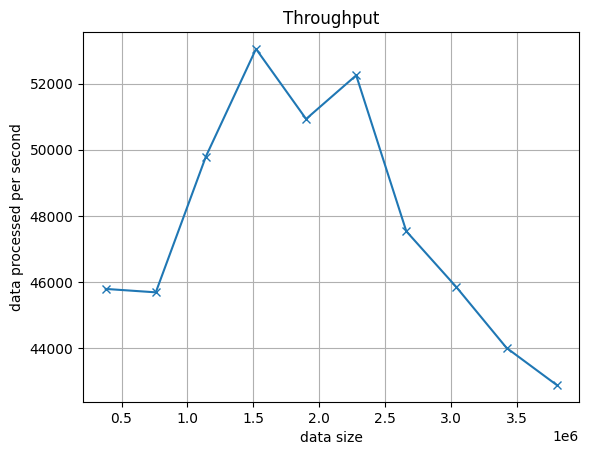

In [158]:
# print out plot(s)
print(times)
plt.plot(data, throughputs, marker='x', label='Throughput')
plt.xlabel('data size')
plt.ylabel('data processed per second')
plt.title('Throughput')
plt.grid(True)
plt.show()

[8.298442363739014, 16.634366035461426, 22.893605947494507, 28.653147220611572, 37.30608296394348, 43.63636016845703, 55.95786762237549, 66.309326171875, 77.70936059951782, 88.60031867027283]


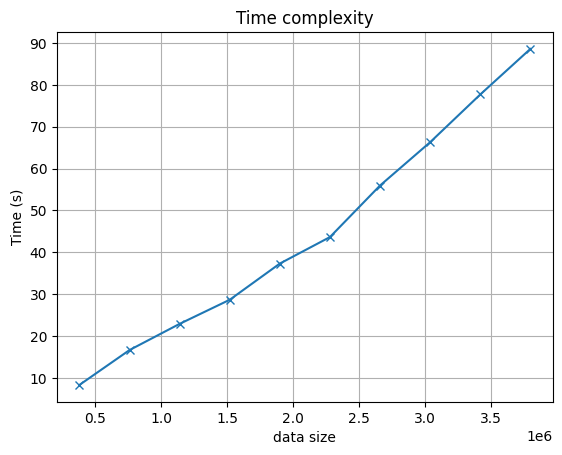

In [159]:
# print out plot(s)
print(times)
plt.plot(data, times, marker='x', label='Throughput')
plt.xlabel('data size')
plt.ylabel('Time (s)')
plt.title('Time complexity')
plt.grid(True)
plt.show()

In [156]:
averagetime = np.mean(times)
print(averagetime)

44.599887776374814


In [ ]:
# 4 cores : average time: 48.11000294685364
# 3 cores : average time: 50.87255311012268
# 2 cores : average time: 55.78757753372192
# 1 cores : average time: 67.99557745456696

In [123]:
T = [67.99557745456696, 55.78757753372192, 50.87255311012268, 48.11000294685364]
cores = [1,2,3,4]

In [ ]:
speedups = []
effeciencies = []

# speedup(n)
for n in range(len(cores)):
    speedup = T[0] / T[n]
    speedups.append(speedup)
print(speedups)

# effeciency(n)

for n in range(1, len(cores)): # to avoid zerodivisionerror
    effeciency = speedups[n] / (n)
    effeciencies.append(effeciency)
print(effeciencies)

[1.0, 1.218830077600442, 1.3365866915973028, 1.4133355495671158]
1
2
3
[1.218830077600442, 0.6682933457986514, 0.47111184985570526]


# use downstream data for ml models such as seq2seq or sentiment analysis

In [ ]:
# example use case: generate summary given inputted text

from transformers import BartForConditionalGeneration, BartTokenizer

model_name = "facebook/bart-large-cnn"
tokenizer = BartTokenizer.from_pretrained(model_name)
model = BartForConditionalGeneration.from_pretrained(model_name)

text = "Apple Inc. reported strong earnings due to iPhone sales and service revenue."

# Encode input
inputs = tokenizer(text, return_tensors="pt", max_length=1024, truncation=True)

# Generate summary
summary_ids = model.generate(inputs["input_ids"], max_length=40, num_beams=4, early_stopping=True)

# Decode output
summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)

print(summary)

KeyboardInterrupt: 